1. Data Processing

In [ ]:
import pandas as pd
import numpy as np
adult_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None, skipinitialspace=True)

In [3]:
list_of_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"]
adult_df.columns = list_of_columns
adult_df.shape

In [7]:
#adult_df = adult_df.loc[:, adult_df.columns != 'fnlwgt']
adult_df.salary = adult_df.salary.replace(to_replace=["<=50K" , ">50K"], value=[0, 1])

//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [9]:
adult_df.head(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [14]:
y = adult_df["salary"]
print('y shape', y.shape)
X = adult_df.loc[:, adult_df.columns != 'salary']
print('x shape', X.shape)

y shape (32561,)
x shape (32561, 13)


In [15]:
X_encoded = pd.get_dummies(X)
X_encoded.shape

(32561, 107)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=101)
print('y_train shape', y_train.shape)
print('y_test shape', y_test.shape)
print('x_train shape', X_train.shape)
print('x_test shape', X_test.shape)


y_train shape (22792,)
y_test shape (9769,)
x_train shape (22792, 107)
x_test shape (9769, 107)


2. Random Forest Classifier - Base Model:

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as skm

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)
y_train_predprob_rf = rf.predict_proba(X_train) 
y_test_predprob_rf = rf.predict_proba(X_test) 

In [18]:
print("Random Forest Training Confusion Matrix")
print(skm.confusion_matrix(y_train, y_train_pred_rf))
print("\nRandom Forest Training Classification Report")
print(skm.classification_report(y_train, y_train_pred_rf))
print("\nTest ROC AUC:", skm.roc_auc_score(y_train, y_train_predprob_rf[:,1]))

Random Forest Training Confusion Matrix
[[17126   158]
 [  299  5209]]

Random Forest Training Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17284
           1       0.97      0.95      0.96      5508

    accuracy                           0.98     22792
   macro avg       0.98      0.97      0.97     22792
weighted avg       0.98      0.98      0.98     22792


Test ROC AUC: 0.9978189925759876


In [19]:
print("Random Forest Test Confusion Matrix")
print(skm.confusion_matrix(y_test, y_test_pred_rf))
print("\nRandom Forest Test Classification Report")
print(skm.classification_report(y_test, y_test_pred_rf))
print("\nTest ROC AUC:", skm.roc_auc_score(y_test, y_test_predprob_rf[:,1]))

Random Forest Test Confusion Matrix
[[6843  593]
 [ 862 1471]]

Random Forest Test Classification Report
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      7436
           1       0.71      0.63      0.67      2333

    accuracy                           0.85      9769
   macro avg       0.80      0.78      0.79      9769
weighted avg       0.85      0.85      0.85      9769


Test ROC AUC: 0.8934414937168078


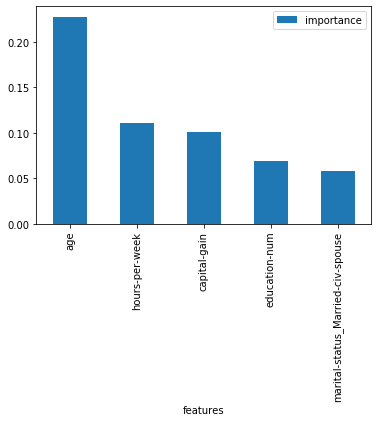

In [23]:
fi_rf = pd.DataFrame({'features': X_train.columns, 'importance': rf.feature_importances_})
fi_rf.sort_values('importance', ascending=False, inplace=True)
fi_rf.iloc[:5,].plot.bar(x='features', y='importance')

f) Using the model from part B, predict for the train data. Look at the classification report for the train data - is there overfitting for the RandomForest model happening?

Answer: There are signs of overfitting. First, the training ROC AUC score for trainning is extremely high (0.9978), which is an sign of overfitting. Further, the trianing precision, recall, accuracy and ROC AUC scores are very high (all in the high 90s%) while the testing precision, recall accuracy and ROC AUC scores are relatively lower (especially for class 1 (salary >50K) are in the low 70%), which is an indication that the model fits very well with the training data but not so well with the testing data (overfitting).

3. AdaBoost Classifier - GridSearch:

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

#create a dictionary of parameters 
param_grid = {
'n_estimators':[100, 200, 300, 400],
'learning_rate':[0.2,0.4,0.6,0.8,1, 1.2],
'random_state':[101]}

abc_obj=AdaBoostClassifier()

# Create gridsearch object with various combinations of parameters
abc_Grid = GridSearchCV(abc_obj, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)

abc_Grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  7.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2],
                         'n_estimators': [100, 200, 300, 400],
                         'random_state': [101]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=5)

In [27]:
abc_Grid.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.2,
                   n_estimators=400, random_state=101)

In [28]:
abc = abc_Grid.best_estimator_

y_train_pred_abc = abc.predict(X_train)
y_test_pred_abc = abc.predict(X_test)

y_train_predprob_abc = abc.predict_proba(X_train)
y_test_predprob_abc = abc.predict_proba(X_test)

In [29]:
print("AdaBoost Classifier Training Confusion Matrix")
print(skm.confusion_matrix(y_train, y_train_pred_abc))
print("\nAdaBoost Classifier Training Classification Report")
print(skm.classification_report(y_train, y_train_pred_abc))
print("\nAdaBoost Classifier Training ROC AUC:", skm.roc_auc_score(y_train, y_train_predprob_abc[:,1]))


AdaBoost Classifier Training Confusion Matrix
[[16276  1008]
 [ 1903  3605]]

AdaBoost Classifier Training Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17284
           1       0.78      0.65      0.71      5508

    accuracy                           0.87     22792
   macro avg       0.84      0.80      0.82     22792
weighted avg       0.87      0.87      0.87     22792


AdaBoost Classifier Training ROC AUC: 0.9305267321084966


In [30]:
print("AdaBoost Classifier Testing Confusion Matrix")
print(skm.confusion_matrix(y_test, y_test_pred_abc))
print("\nAdaBoost Classifier Testing Classification Report")
print(skm.classification_report(y_test, y_test_pred_abc))
print("\nAdaBoost Classifier Testing ROC AUC:", skm.roc_auc_score(y_test, y_test_predprob_abc[:,1]))


AdaBoost Classifier Testing Confusion Matrix
[[6991  445]
 [ 810 1523]]

AdaBoost Classifier Testing Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7436
           1       0.77      0.65      0.71      2333

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769


AdaBoost Classifier Testing ROC AUC: 0.9276982414532284


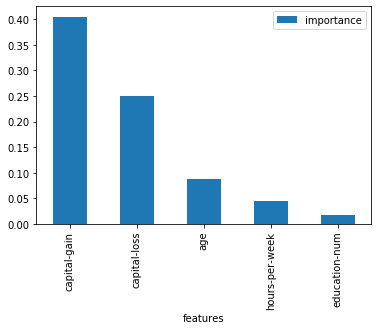

In [31]:
fi_abc = pd.DataFrame({'features': X_train.columns, 'importance': abc.feature_importances_})
fi_abc.sort_values('importance', ascending=False, inplace=True)
fi_abc.iloc[:5,].plot.bar(x='features', y='importance')

f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

Answer: There is no sign of overfitting because the testing and training precision rates and recall rates for each class as well as the overall accuracy rate are very similar, which suggest that there is no obvious overfitting in the training model. A sign of overfitting is when the training accuracy score and precision rates and/or recall rates are high while the testing accuracy score and precision rates and/or recall rates are low.

4. Gradient Boosting Classifier - GridSearch:

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

#create a dictionary of parameters 
param_grid = {
'n_estimators':[100, 200, 300, 400],
'learning_rate':[0.2, 0.8, 1.2],
'max_depth':[1,2],    
'random_state':[101]}

gbc_obj=GradientBoostingClassifier()

# Create gridsearch object with various combinations of parameters
gbc_Grid = GridSearchCV(gbc_obj, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)

gbc_Grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...one,
             

In [34]:
gbc_Grid.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=101, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [35]:
gbc = gbc_Grid.best_estimator_

y_train_pred_gbc = gbc.predict(X_train)
y_test_pred_gbc = gbc.predict(X_test)

y_train_predprob_gbc = gbc.predict_proba(X_train)
y_test_predprob_gbc = gbc.predict_proba(X_test)

In [36]:
print("Gradient Boosting Classifier Training Confusion Matrix")
print(skm.confusion_matrix(y_train, y_train_pred_gbc))
print("\nGradient Boosting Classifier Training Classification Report")
print(skm.classification_report(y_train, y_train_pred_gbc))
print("\nGradient Boosting Classifier Training ROC AUC:", skm.roc_auc_score(y_train, y_train_predprob_gbc[:,1]))


Gradient Boosting Classifier Training Confusion Matrix
[[16365   919]
 [ 1837  3671]]

Gradient Boosting Classifier Training Classification Report
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     17284
           1       0.80      0.67      0.73      5508

    accuracy                           0.88     22792
   macro avg       0.85      0.81      0.82     22792
weighted avg       0.88      0.88      0.88     22792


Gradient Boosting Classifier Training ROC AUC: 0.9366870243816109


In [37]:
print("Gradient Boosting Classifier Testing Confusion Matrix")
print(skm.confusion_matrix(y_test, y_test_pred_gbc))
print("\nGradient Boosting Classifier Testing Classification Report")
print(skm.classification_report(y_test, y_test_pred_gbc))
print("\nGradient Boosting Classifier Testing ROC AUC:", skm.roc_auc_score(y_test, y_test_predprob_gbc[:,1]))


Gradient Boosting Classifier Testing Confusion Matrix
[[7022  414]
 [ 794 1539]]

Gradient Boosting Classifier Testing Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7436
           1       0.79      0.66      0.72      2333

    accuracy                           0.88      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.88      0.87      9769


Gradient Boosting Classifier Testing ROC AUC: 0.9298699668230481


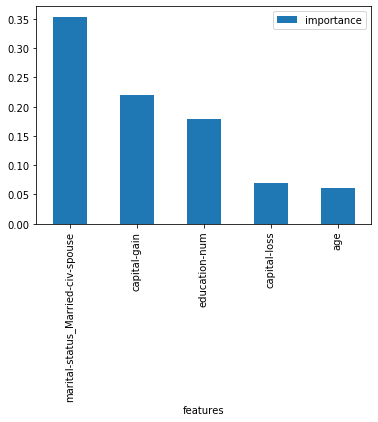

In [38]:
fi_gbc = pd.DataFrame({'features': X_train.columns, 'importance': gbc.feature_importances_})
fi_gbc.sort_values('importance', ascending=False, inplace=True)
fi_gbc.iloc[:5,].plot.bar(x='features', y='importance')

f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

Answer: There is no sign of overfitting because the testing and training precision rates and recall rates for each class as well as the overall accuracy rate are very similar, which suggest that there is no obvious overfitting in the training model. A sign of overfitting is when the training accuracy score and precision rates and/or recall rates are high while the testing accuracy score and precision rates and/or recall rates are low.

5. XGBoost - RandomizedSearchCV

In [52]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

#create a dictionary of parameters 
param_grid = {
'n_estimators':[100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000],
'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6],
'max_depth':[1,2],
'gamma':[0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5],    
'random_state':[101]}

xgb_obj=XGBClassifier()

# Create gridsearch object with various combinations of parameters
xgb_Grid = RandomizedSearchCV(xgb_obj, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)

xgb_Grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           se...
                                                  3, 3.25, 3.5, 3.75, 4, 4.25,
                                                  4.5, 4.75, 5],
                                 

In [53]:
xgb_Grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=2, learning_rate=1.4, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=None, n_estimators=500,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=101, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [54]:
xgb = xgb_Grid.best_estimator_

y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)

y_train_predprob_xgb = xgb.predict_proba(X_train)
y_test_predprob_xgb = xgb.predict_proba(X_test)

In [55]:
print("XGBoost Classifier Training Confusion Matrix")
print(skm.confusion_matrix(y_train, y_train_pred_xgb))
print("\nXGBoost Classifier Training Classification Report")
print(skm.classification_report(y_train, y_train_pred_xgb))
print("\nXGBoost Classifier Training ROC AUC:", skm.roc_auc_score(y_train, y_train_predprob_xgb[:,1]))


XGBoost Classifier Training Confusion Matrix
[[16258  1026]
 [ 1888  3620]]

XGBoost Classifier Training Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17284
           1       0.78      0.66      0.71      5508

    accuracy                           0.87     22792
   macro avg       0.84      0.80      0.82     22792
weighted avg       0.87      0.87      0.87     22792


XGBoost Classifier Training ROC AUC: 0.9277215562997552


In [56]:
print("XGBoost Classifier Testing Confusion Matrix")
print(skm.confusion_matrix(y_test, y_test_pred_xgb))
print("\nXGBoost Classifier Testing Classification Report")
print(skm.classification_report(y_test, y_test_pred_xgb))
print("\nXGBoost Classifier Testing ROC AUC:", skm.roc_auc_score(y_test, y_test_predprob_xgb[:,1]))


XGBoost Classifier Testing Confusion Matrix
[[6980  456]
 [ 795 1538]]

XGBoost Classifier Testing Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7436
           1       0.77      0.66      0.71      2333

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769


XGBoost Classifier Testing ROC AUC: 0.9263940994875084


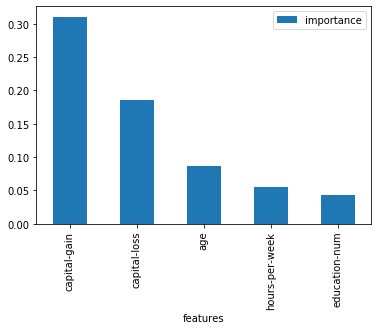

In [57]:
fi_xgb = pd.DataFrame({'features': X_train.columns, 'importance': xgb.feature_importances_})
fi_xgb.sort_values('importance', ascending=False, inplace=True)
fi_xgb.iloc[:5,].plot.bar(x='features', y='importance')

f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

There is no sign of overfitting because the testing and training precision rates and recall rates for each class as well as the overall accuracy rate are very similar, which suggest that there is no obvious overfitting in the training model. A sign of overfitting is when the training accuracy score and precision rates and/or recall rates are high while the testing accuracy score and precision rates and/or recall rates are low.

6. Moving into Conceptual Problems:

a) What does the alpha parameter represent in AdaBoost? Please refer to chapter 7 of the Hands-On ML book if you are struggling.

Answer: AdaBoost is an iterative ensemble boosting classifier. It builds a stronger classifier by combining multiple poorly performing classifiers. Alpha is the weight applied to classifier as determined by AdaBoost. The basic concept behind Adaboost is to set the weights (alpha) of classifiers and training the data sample in each iteration such that it ensures the accurate predictions of unusual observations through iterations (multiple weak classifiers). 

b) In AdaBoost explain how the final predicted class is determined. Be sure to reference the alpha term in your explanation.

To determine the final predicted class in AdaBoost, we take a testing sample and fit it into each of the weak classifiers, and multiply the outputs with the alpha weights of each weak classifier. Then we perform a sum or majority vote of the final output of these weak classifiers and determined which class does this testing sample belongs to. For instance, for  a binary classification problem, with 3 weak classifiers, the classification output might be 1,-1,-1 (where 1 is class A and -1 is class B), and we multiply the weights with each classifiers (e.g. 0.2, 0.5, 0.3), the sum is -0.6, in which we will classify this sample to class B. 

c) In Gradient Boosting, what is the role of the max_depth parameter? Why is it important to tune on this parameter?

Answer: The role of the max depth parameter is determine the depth of the individual tree classifier. Boosting is a sequential technique which works on the principle of ensemble. In Gradient Boosting, the model learns from weak learns to improve accuracy and build a stronger learner. The learners that predicted correctly are given a lower weight and the ones misclassified are given higher weight. The max depth parameter could be used to control the learning rate of the boosting model as well as to help prevent overfit. Trees with fewer nodes/less depth are normally weaker, which is good for a boosting algorithm and will be given more weight to be learnt in the next sequence. Therefore, the max depth can control the amount of learning gained from each sequence. In addition, controlling the max depth parameter can help prevent overfitting a classification tree since the deeper the tree, the higher chance that it could contain information that is specific to the training data.


d) In Part (e) of Steps 2-5 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if this predictor makes sense given what you are attempting to predict. (Note: If you don't have any predictors showing up across all 3 predictors, explain one that shows up in 2 of them).

Answer: There are a few predictors show up in the top 5 predictors for all three models: Capital Gain, Capital Loss, Age, and Education Number. These predictors make sense given that we are trying to predict whethere one's salary is higher than 50k or not. Capital Gain and Capital Loss make sense because this can show if one is actively managing his/her moeny through investment, and we can see if he/she gain or loss any money on top of his/her basic salary. Age and Education number make sense as we would normally think that people who has more working experience (typically can be determined by age) and higher education tend to have better job offer and higher salary. 

e) From the models run in steps 2-5, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyperparameters found from your grid search.

Answer: From the models run in steps 2-5, Gradient Boosting Classifier performs the best based on the classification report. Even though Random Forest Classifier (step 20 has the highest training accuracy rate, the significant difference between training and testing scores indicates that there is sign of overfitting. Hence, we are not considering this model. For Gradient Boosting Classifier, the optimal hyperparameter found from the grid search is learning rate of 0.2, n estimators of 400, and max depth of 2. The accuracy rates are very similar across all models. The highest accuracy rate for testing and training is 88% from Gradient Boosting Classifier, and it also has slightly higher precision and recall rates as well as ROC AUC rate for both training and testing data. The difference between training and testing rates are very small, which does not indicate any sign of overfitting. Therefore, based on the classification report, Gradient Boosting Classifier performs the best.

f) For your best performing model, plot out a ROC curve using your test data. Feel free to use sklearn, matplotlib or any other method in python. Describe what the x-axis & y-axis of the ROC curve tell us about a classifier.

Text(0.5, 0, 'False Positive Rate')

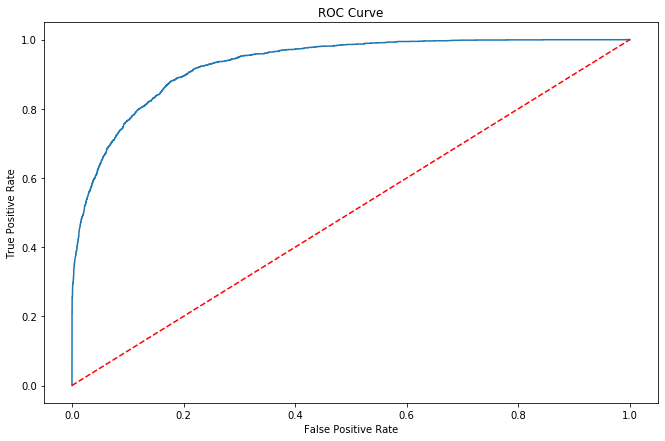

In [59]:
import matplotlib.pyplot as plt

fpr, tpr, threshold = skm.roc_curve(y_test, y_test_predprob_gbc[:,1])
roc_auc = skm.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(fpr, tpr)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Answer: The y-axis is the True Positive Rate, or the Recall rate or Sensitivity rate, which is calculated by using true positive divided by the sum of true positive and false negative. The x-axis is the False Positive Rate, which is calculated by using one minus the specificity (false positive divided by the sum of true negative and false positive). When ROC AUC rate is 1, the model has a perfect separabiltiy meaning it has the ablity to separate the two classes perfectly well. However, the ROC AUC rate is 0, the model is classifying the sample into a reciprocal class (all class 1 samples will be classified as class 2 and vise versa). When the ROC AUC rate is 0.5, the model does not have any ability to classify between classes. 